In [2]:
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
import numpy as np
from plotly.subplots import make_subplots
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import functions as f
from sklearn.cluster import KMeans
import plotly.express as px
import plotly.graph_objects as go
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
import geopandas as gpd
from pyproj import CRS
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt

In [4]:
data = pd.read_csv('Clustering/Merged DataFrame.csv', index_col = 0)

datas = StandardScaler(with_mean = False).fit_transform(data)
df_not_scaled = pd.DataFrame(data,columns = data.columns)
df = pd.DataFrame(datas,columns = data.columns)
col = list(df.columns)

# DB Scan

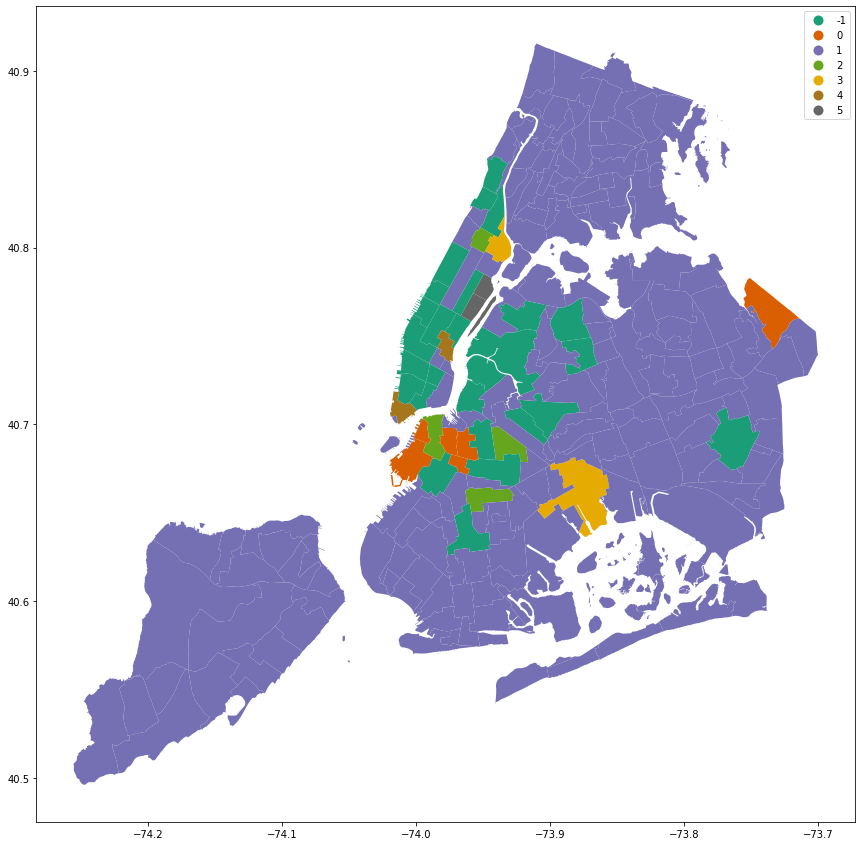

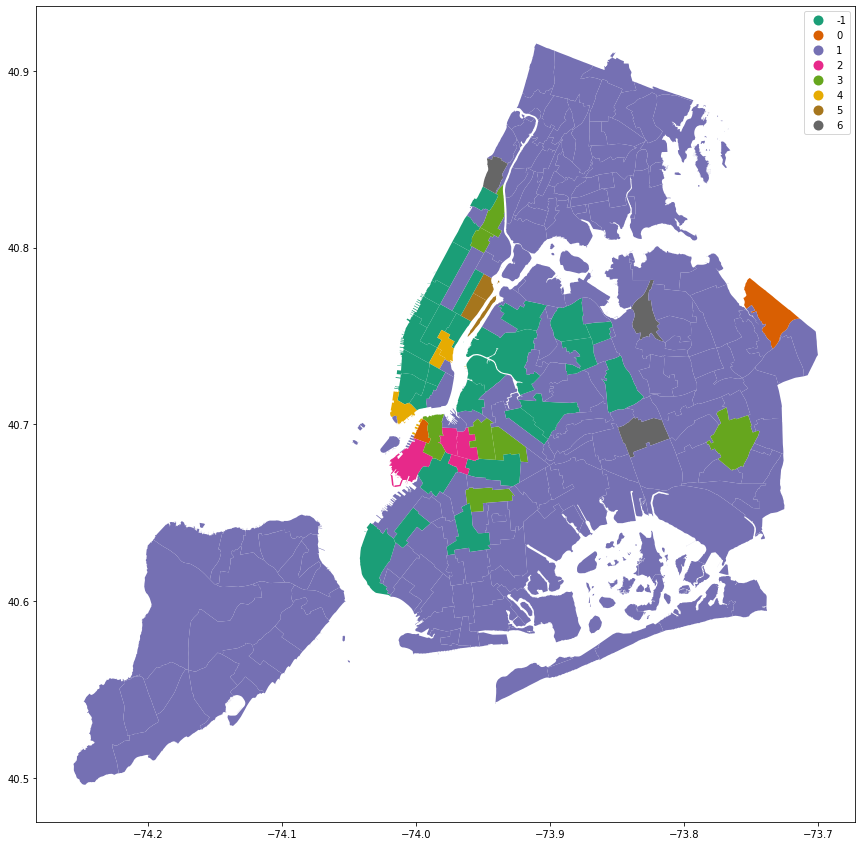

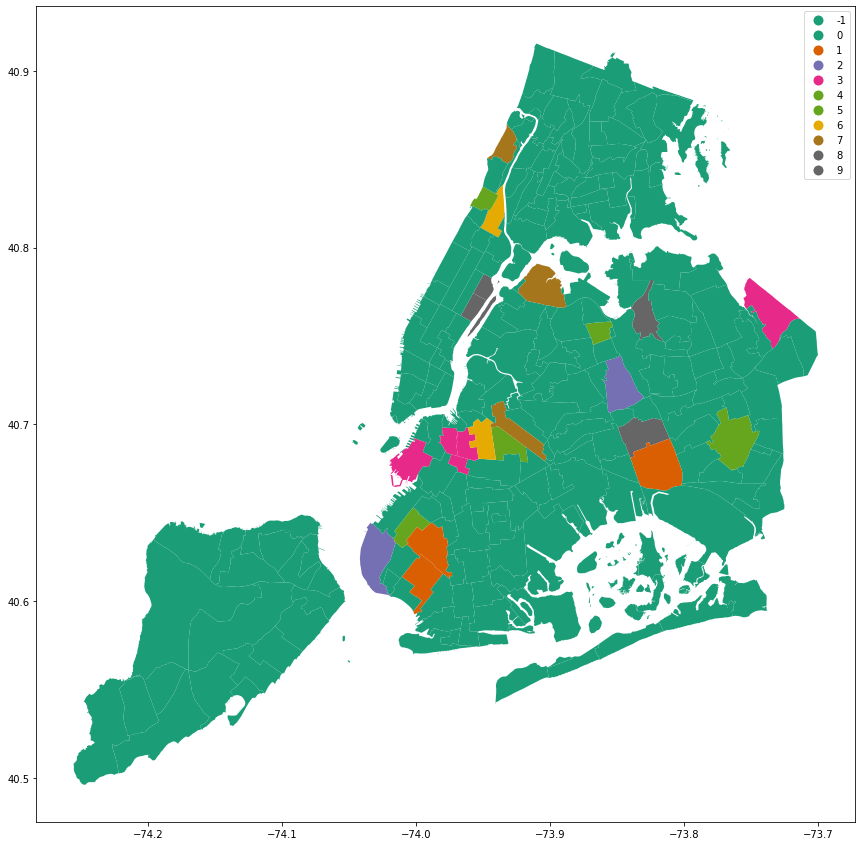

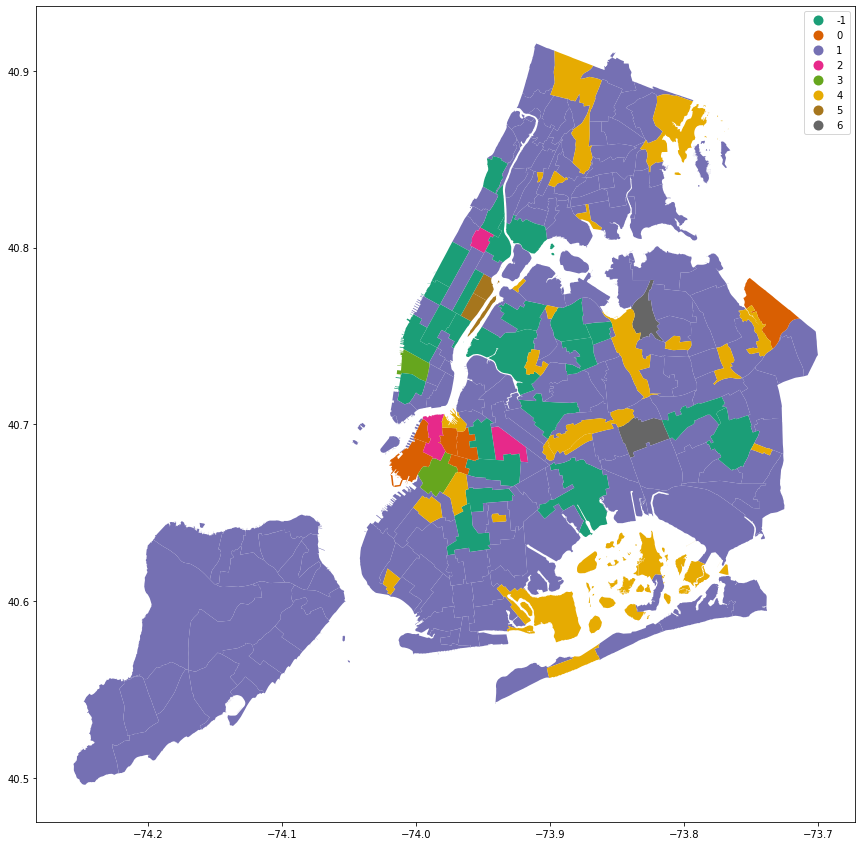

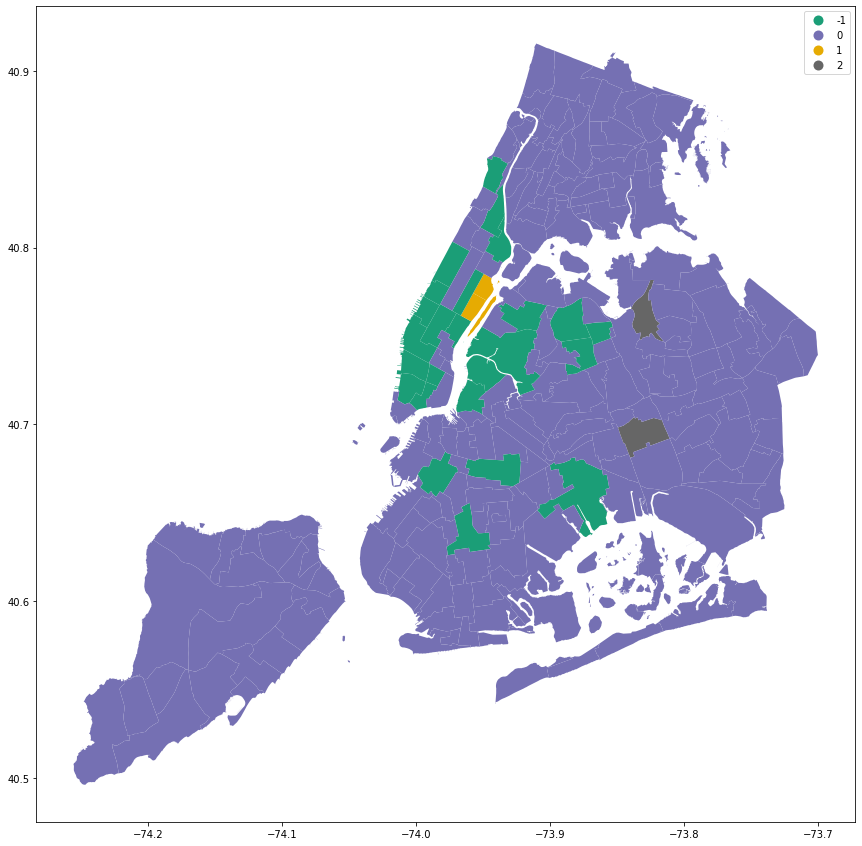

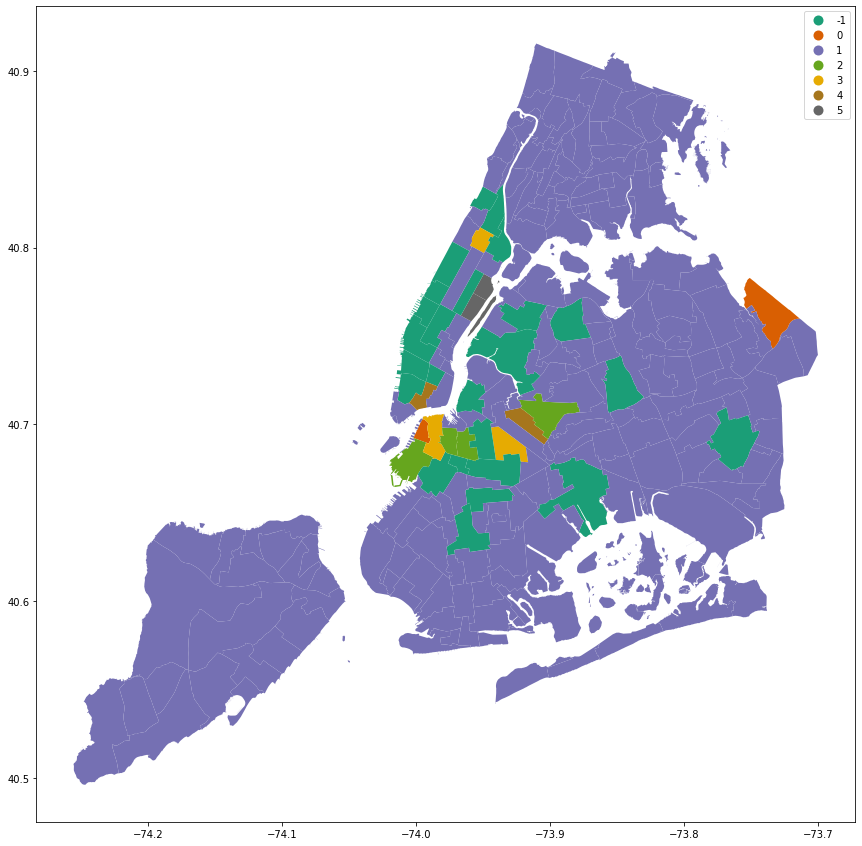

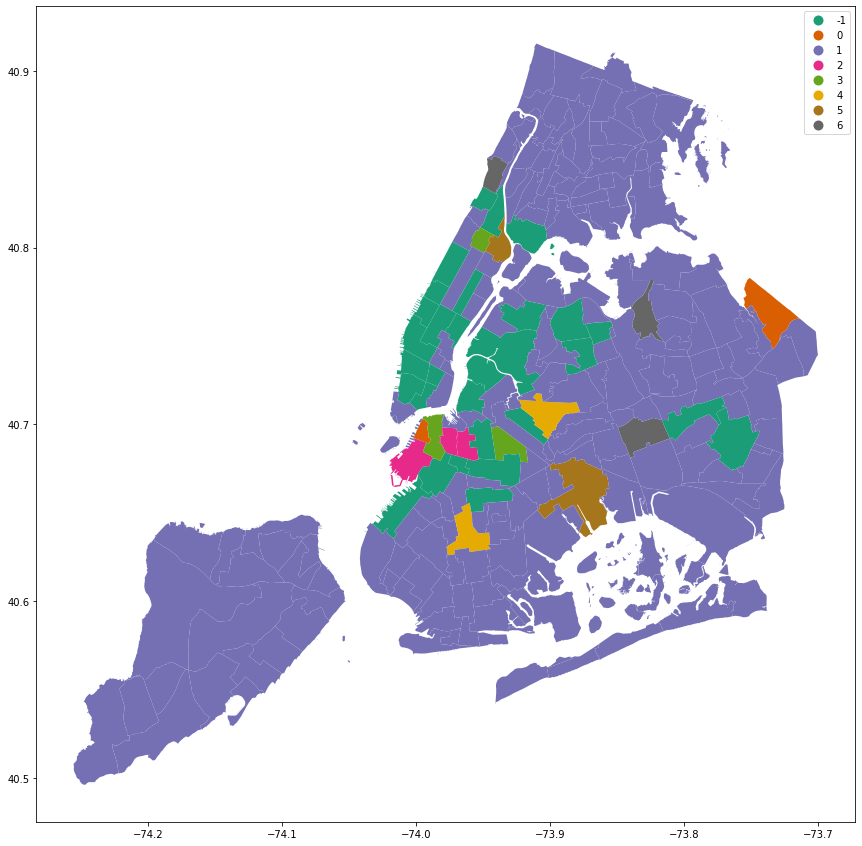

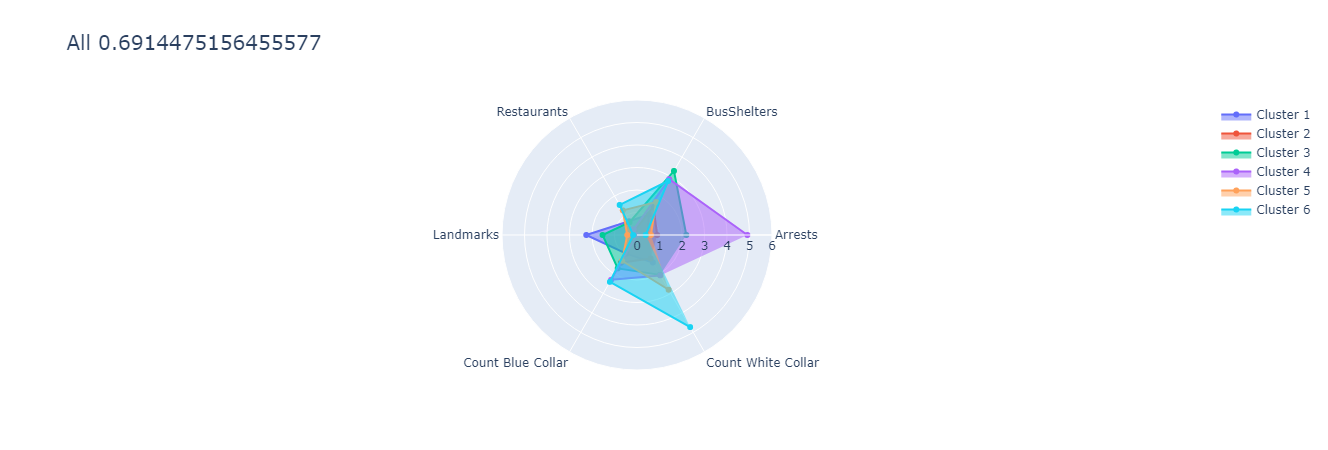

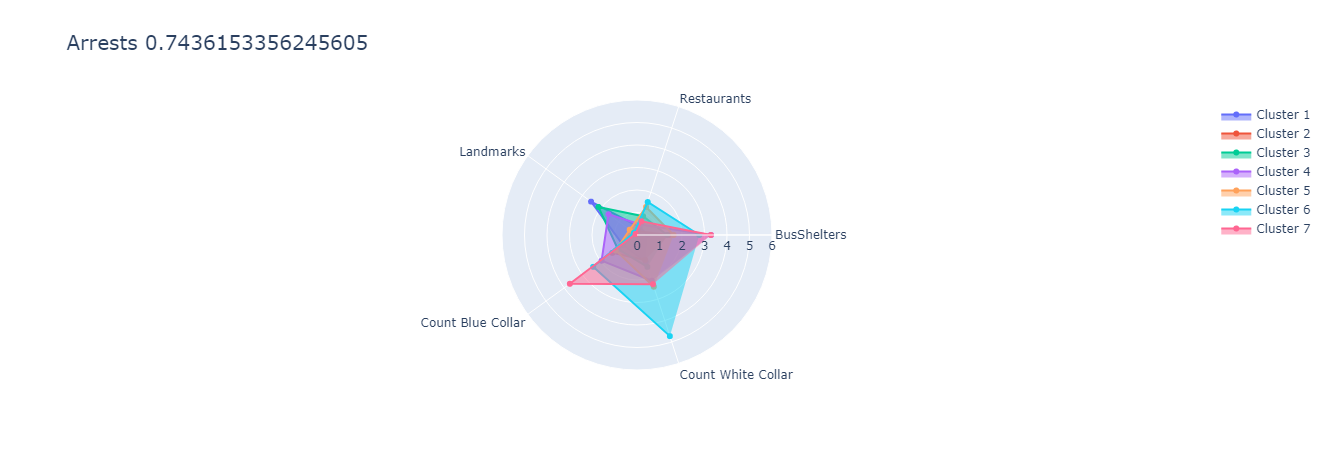

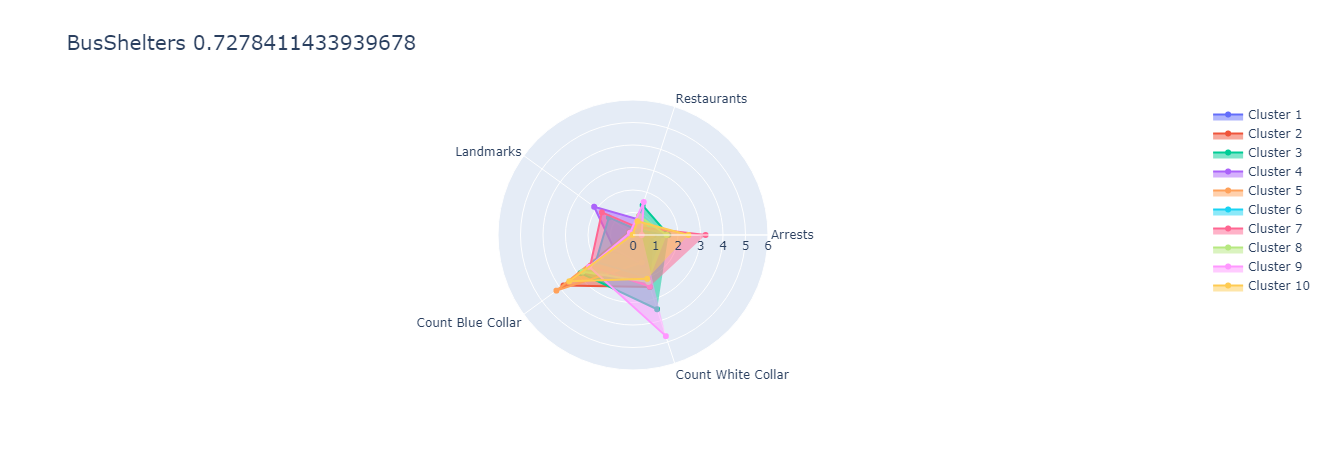

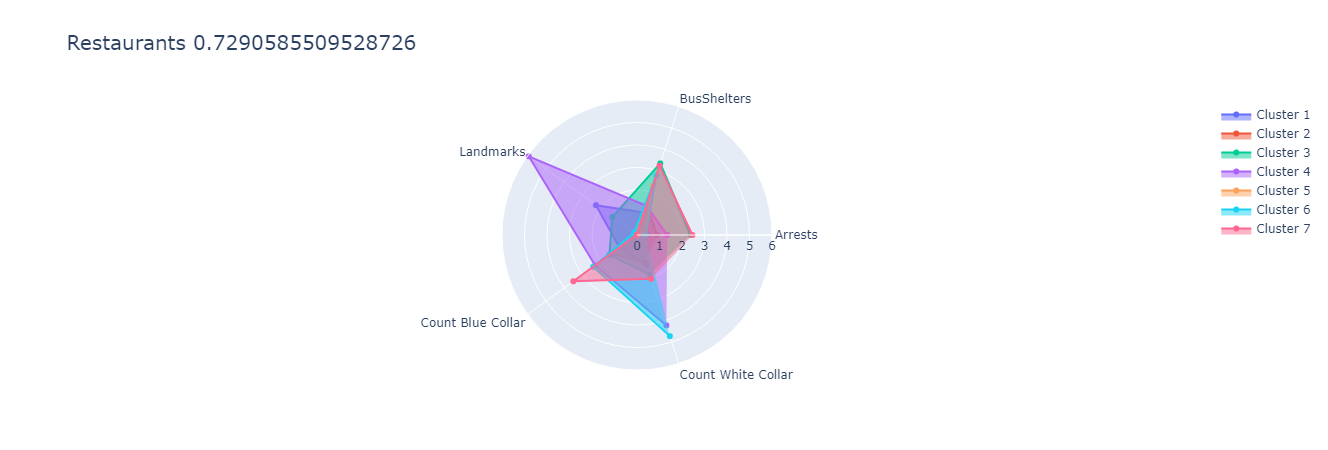

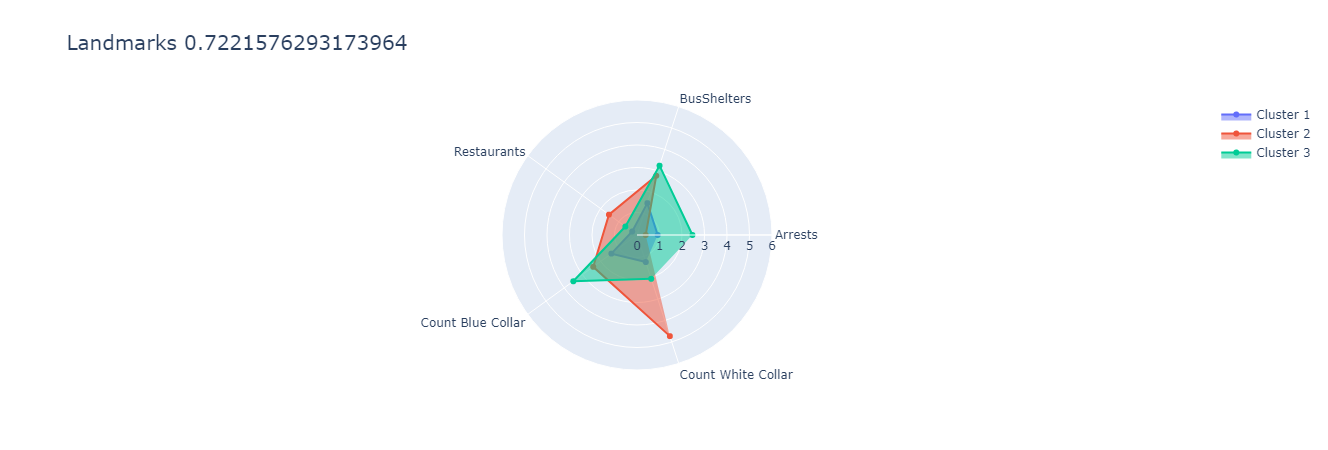

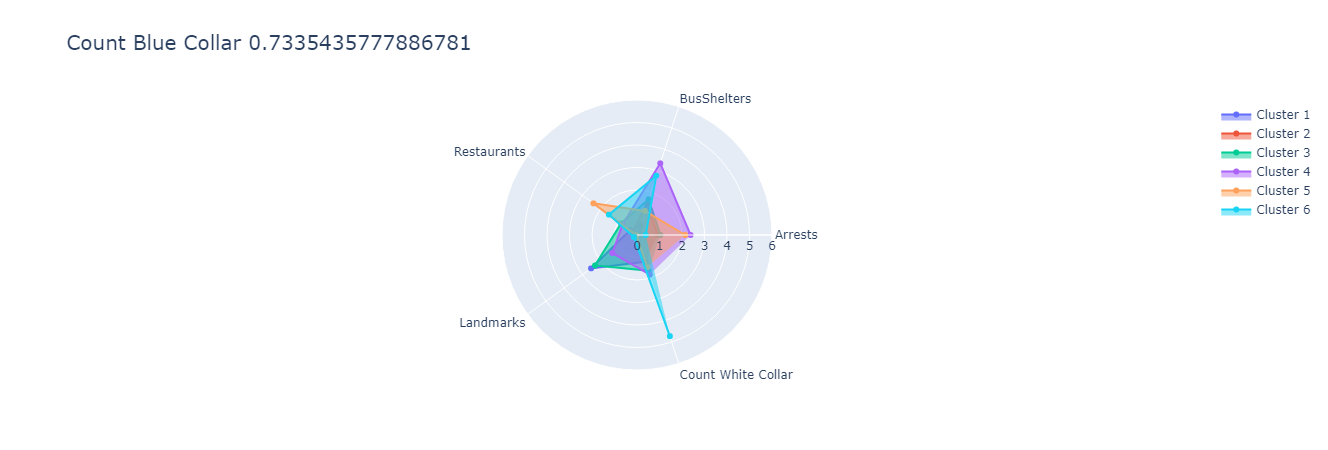

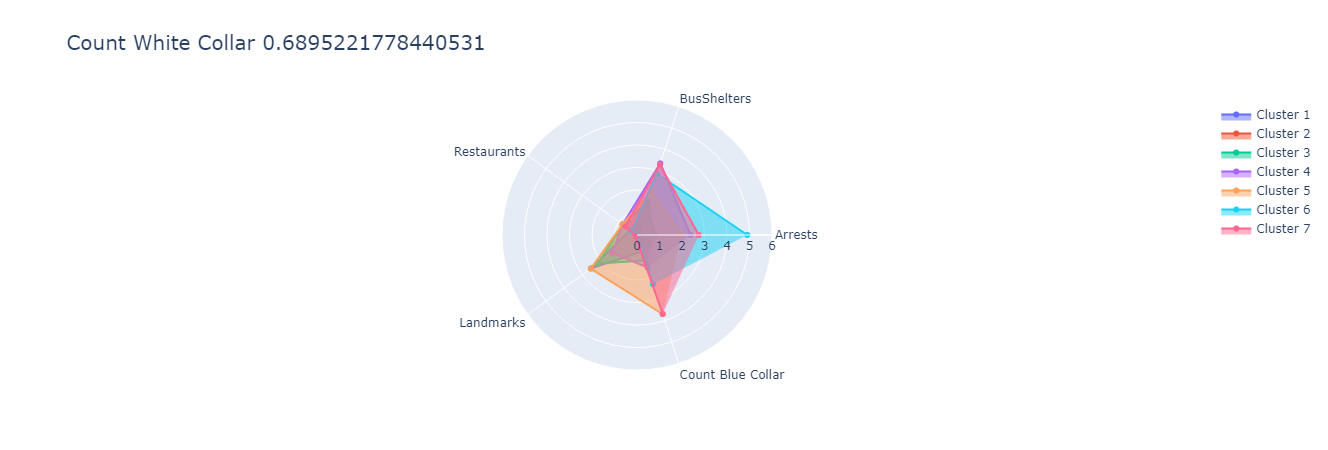

In [6]:
dbscan_dict = {}
new_df = df.copy()
features = list(new_df.columns)

#PCA
PCAb = PCA(n_components=2)
PCA_df = PCAb.fit_transform(new_df)
var = PCAb.explained_variance_ratio_.sum()

#Find true Epsilon
n = 2
nearest_neighbors = NearestNeighbors(n_neighbors=n)
neighbors = nearest_neighbors.fit(new_df)
distances, indices = neighbors.kneighbors(new_df)
distances = np.sort(distances[:,n-1], axis=0)
x = np.arange(len(distances))
knee = KneeLocator(x, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
eps = distances[knee.knee]

#DB scan
db = DBSCAN(eps, min_samples=2)
y_db = db.fit_predict(new_df)
new_df['Cluster'] = y_db+1
nyc = f.visualize_clusters(df_not_scaled,y_db)

#RadarPlot Generation
fig = go.Figure()
for j in range(new_df['Cluster'].nunique()-1):
    fig.add_trace(go.Scatterpolar(r=list(new_df[new_df['Cluster'] == j+1].mean()), theta=features, fill='toself', name='Cluster '+ str(j+1)))
    
fig.update_layout(polar=dict(radialaxis=dict(visible=True,range=[0, 6])), showlegend=True)
     
dbscan_dict['All'] = [var,fig,nyc]


#iterations of dropping features
for i in range(len(col)):
    #drop
    new_df = df.drop(col[i],axis = 1)
    features = list(new_df.columns)
    
    #PCA for variance
    PCAb = PCA(n_components=2)
    PCA_df = PCAb.fit_transform(new_df)
    var = PCAb.explained_variance_ratio_.sum()
    
    #find true epsilon
    n = 2
    nearest_neighbors = NearestNeighbors(n_neighbors=n)
    neighbors = nearest_neighbors.fit(new_df)
    distances, indices = neighbors.kneighbors(new_df)
    distances = np.sort(distances[:,n-1], axis=0)
    x = np.arange(len(distances))
    knee = KneeLocator(x, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
    eps = distances[knee.knee]
    
    #DB scan
    db = DBSCAN(eps, min_samples=2)
    y_db = db.fit_predict(new_df)
    new_df['Cluster'] = y_db+1
    nyc = f.visualize_clusters(df_not_scaled,y_db)
    
    #RadarPlot Generation
    fig = go.Figure()
    for j in range(new_df['Cluster'].nunique()-1):
        fig.add_trace(go.Scatterpolar(r=list(new_df[new_df['Cluster'] == j+1].mean()), theta=features, fill='toself', name='Cluster '+ str(j+1)))
    
    fig.update_layout(polar=dict(radialaxis=dict(visible=True,range=[0, 6])), showlegend=True)
     
    dbscan_dict[col[i]] = [var,fig,nyc]

#Plotting Radar Charts
for x in dbscan_dict:
    dbscan_dict[x][1].update_layout(title_text=x + ' ' + str(dbscan_dict[x][0]),title_font_size=20)
    dbscan_dict[x][1].show()


# K Means

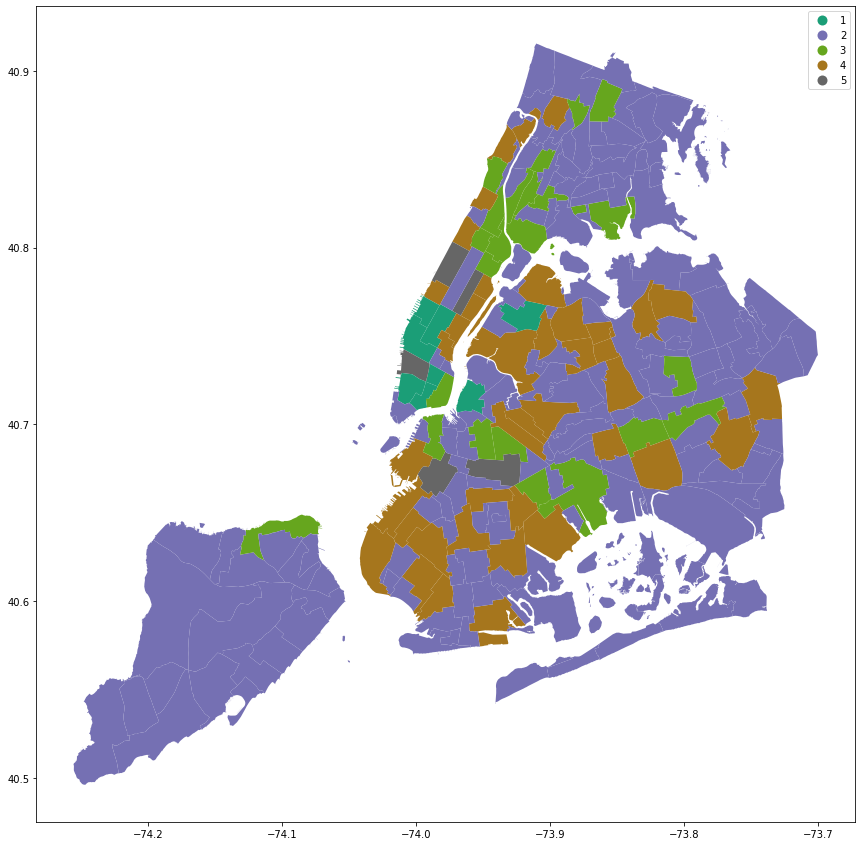

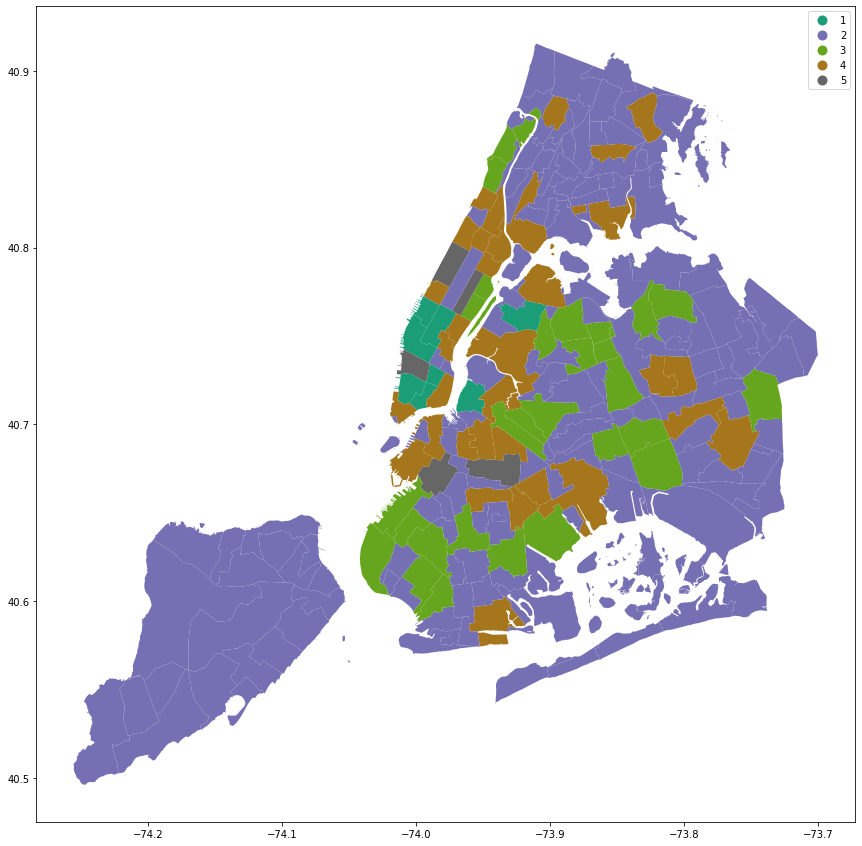

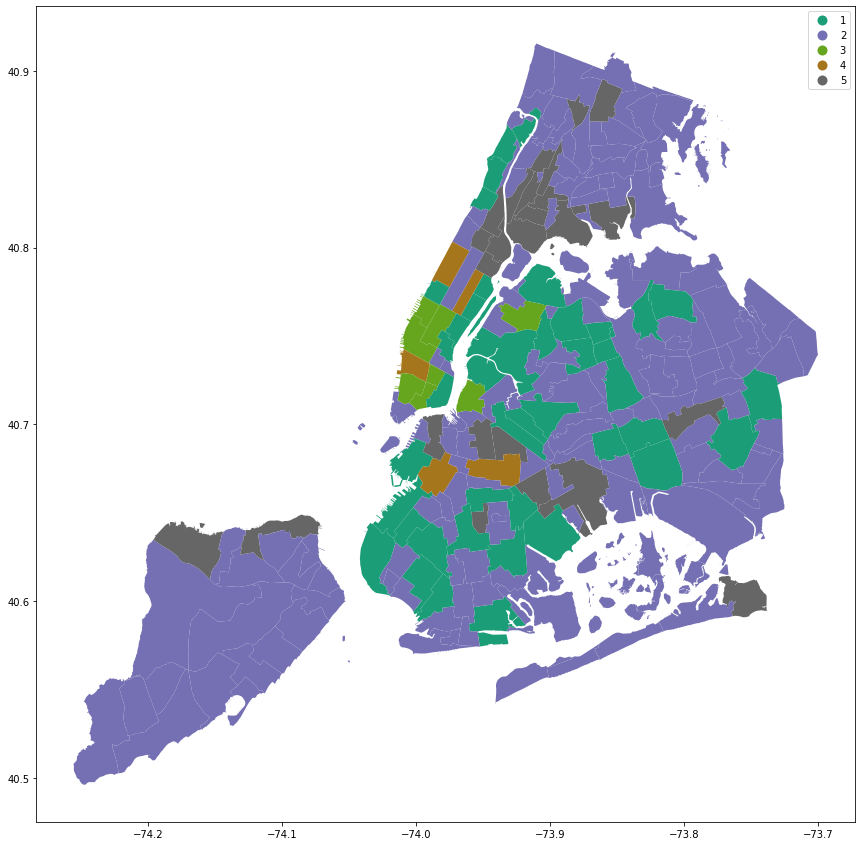

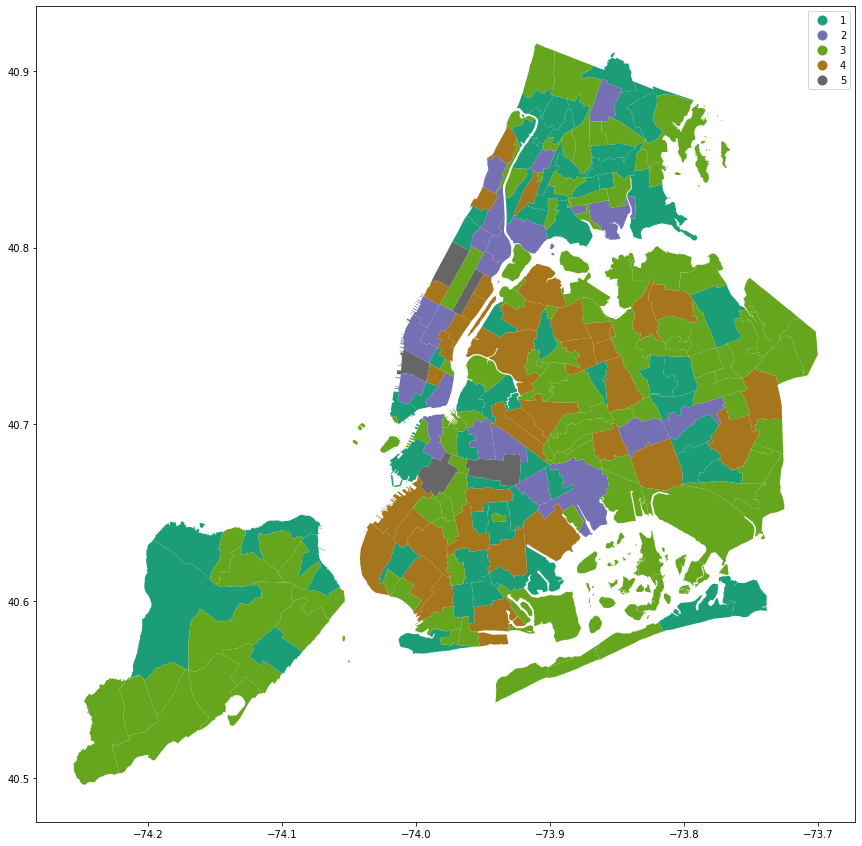

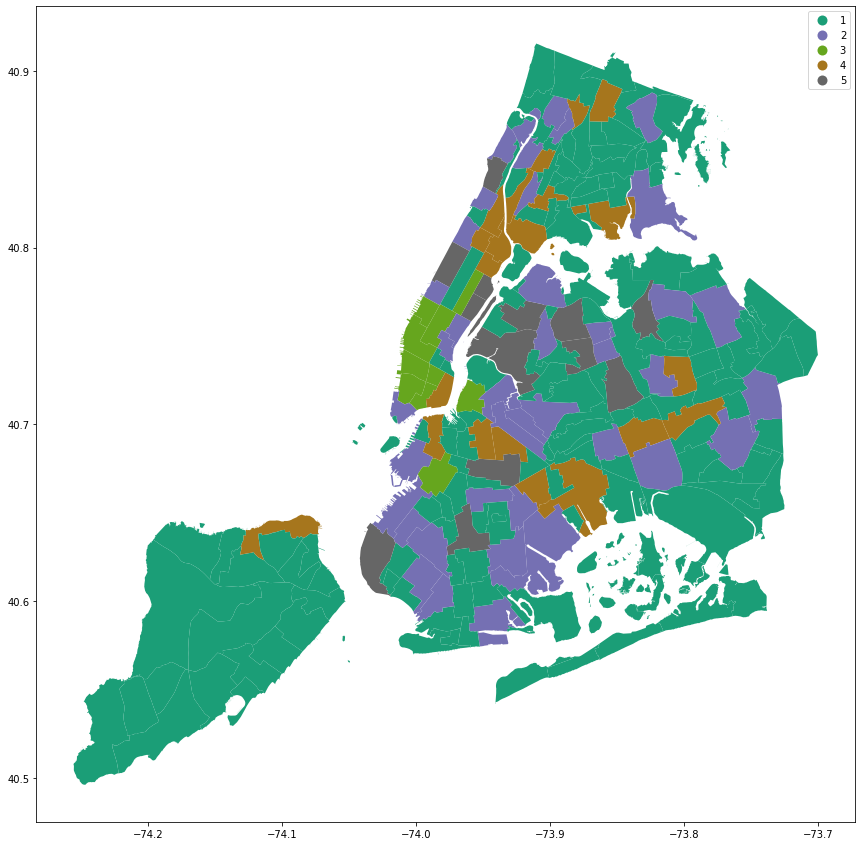

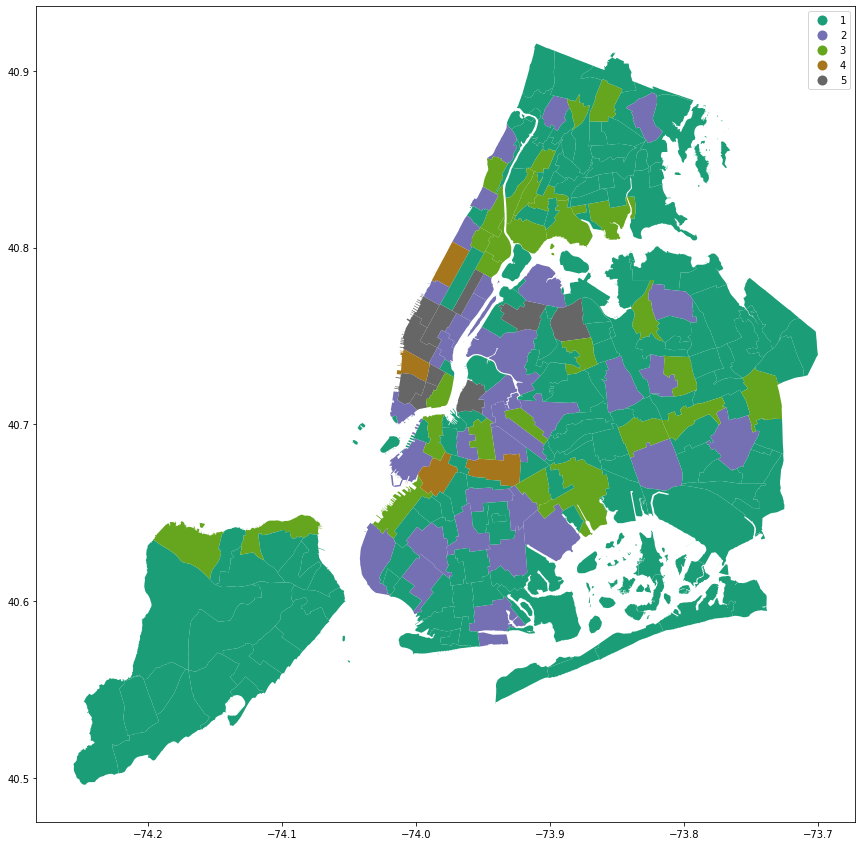

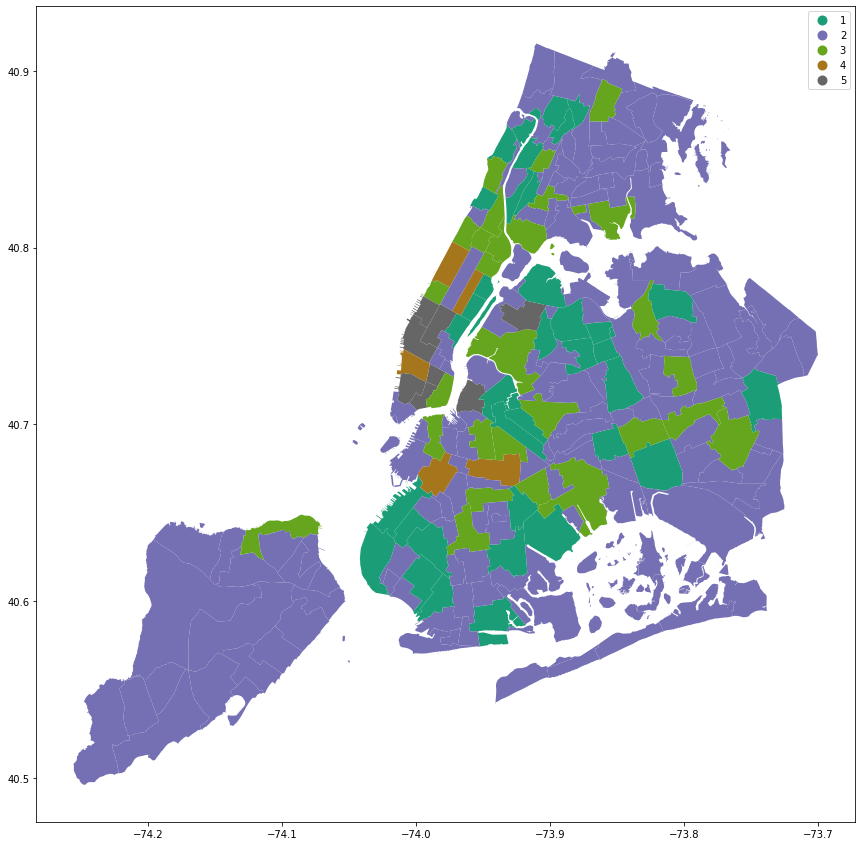

In [7]:
kmeans_dict = {}
clusters = 5
n_init = 20
new_df = df.copy()
features = list(new_df.columns)

#PCA
PCAb = PCA(n_components=2)
PCA_df = PCAb.fit_transform(new_df)
var = PCAb.explained_variance_ratio_.sum()

#KMeans scan
km = KMeans(n_clusters=clusters,n_init=n_init)
y_km = km.fit_predict(new_df)
new_df['Cluster'] = y_km+1
f.visualize_clusters(df_not_scaled,y_km+1)

#RadarPlot Generation
fig = go.Figure()
for j in range(clusters):
    fig.add_trace(go.Scatterpolar(r=list(new_df[new_df['Cluster'] == j+1].mean()), theta=features, fill='toself', name='Cluster '+ str(j+1)))
    
fig.update_layout(polar=dict(radialaxis=dict(visible=True,range=[0, 6])), showlegend=True)
     
kmeans_dict['All'] = [var,fig,nyc]


#iterations of dropping features
for i in range(len(col)):
    #drop
    new_df = df.drop(col[i],axis = 1)
    features = list(new_df.columns)
    
    #PCA for variance
    PCAb = PCA(n_components=2)
    PCA_df = PCAb.fit_transform(new_df)
    var = PCAb.explained_variance_ratio_.sum()
    
    #KMeans scan
    km = KMeans(n_clusters=clusters,n_init=n_init)
    y_km = km.fit_predict(new_df)
    new_df['Cluster'] = y_km+1
    nyc = f.visualize_clusters(df_not_scaled,y_km+1)
    
    #RadarPlot Generation
    fig = go.Figure()
    for j in range(clusters):
        fig.add_trace(go.Scatterpolar(r=list(new_df[new_df['Cluster'] == j+1].mean()), theta=features, fill='toself', name='Cluster '+ str(j+1)))
    
    fig.update_layout(polar=dict(radialaxis=dict(visible=True,range=[0, 6])), showlegend=True)
     
    kmeans_dict[col[i]] = [var,fig]

#Plotting Radar Charts
for x in kmeans_dict:
    kmeans_dict[x][1].update_layout(title_text=x + ' ' + str(kmeans_dict[x][0]),title_font_size=20)
    kmeans_dict[x][1].show()

# Heirarchical

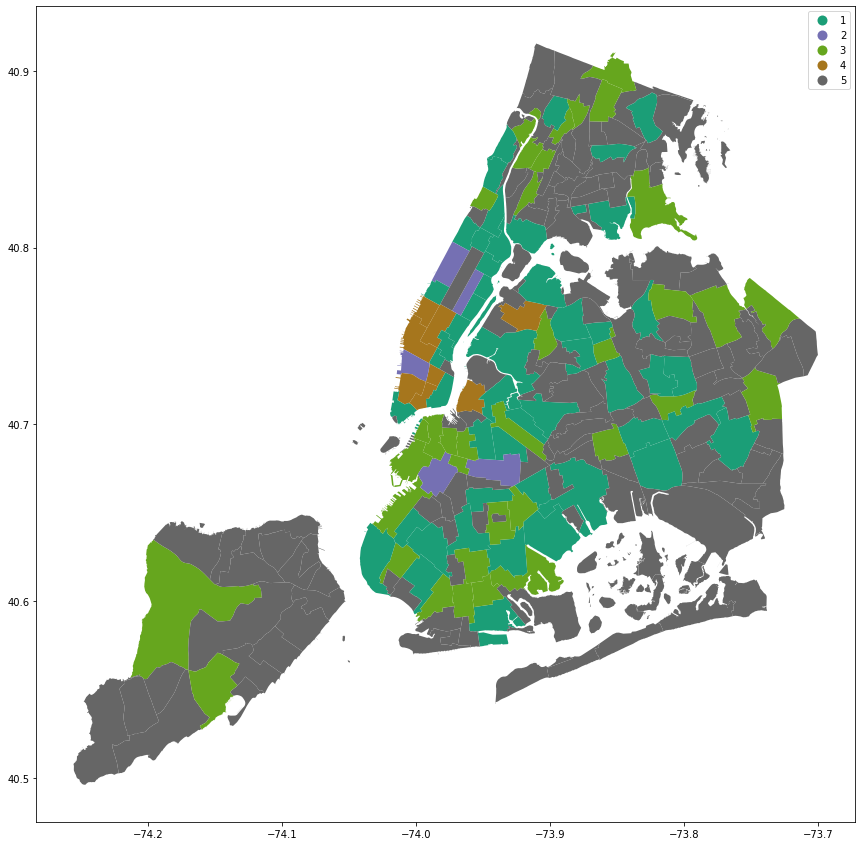

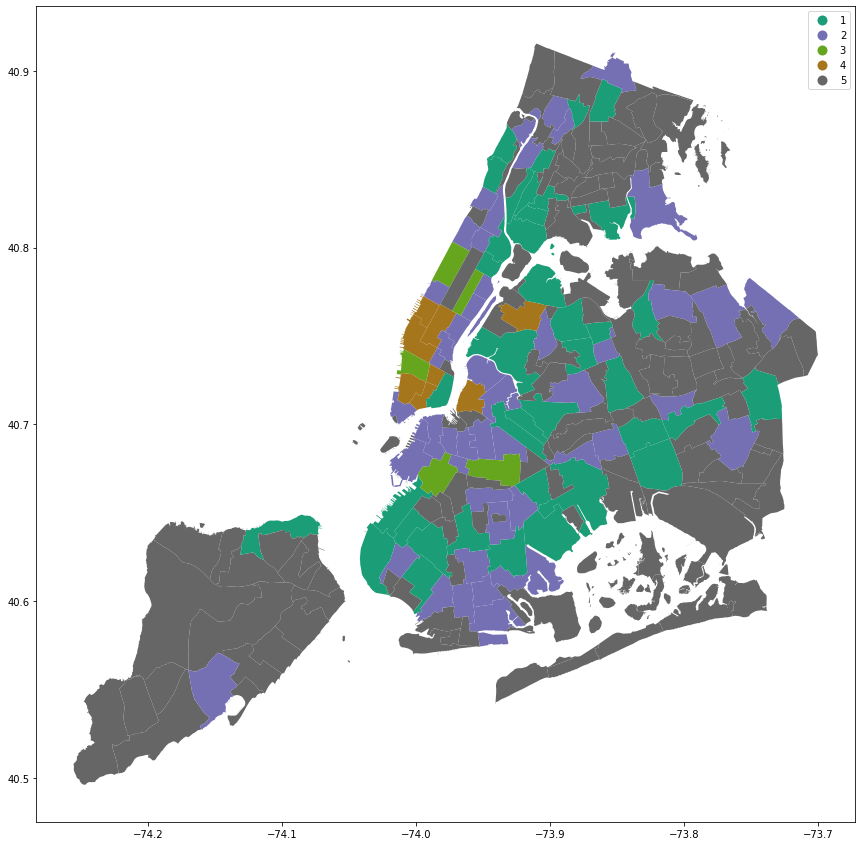

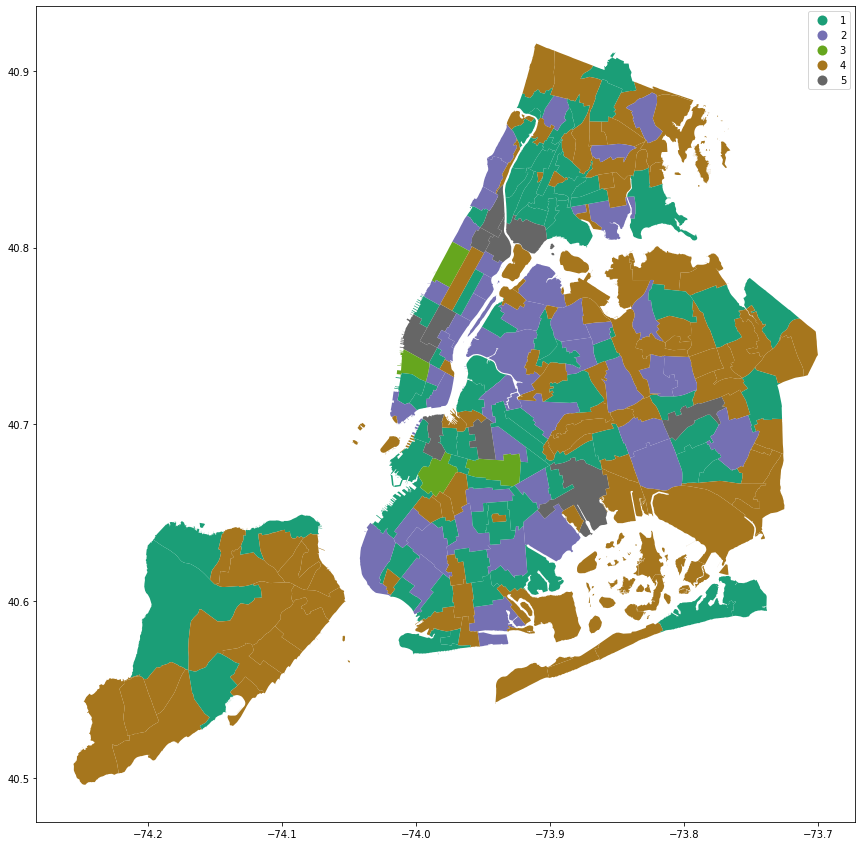

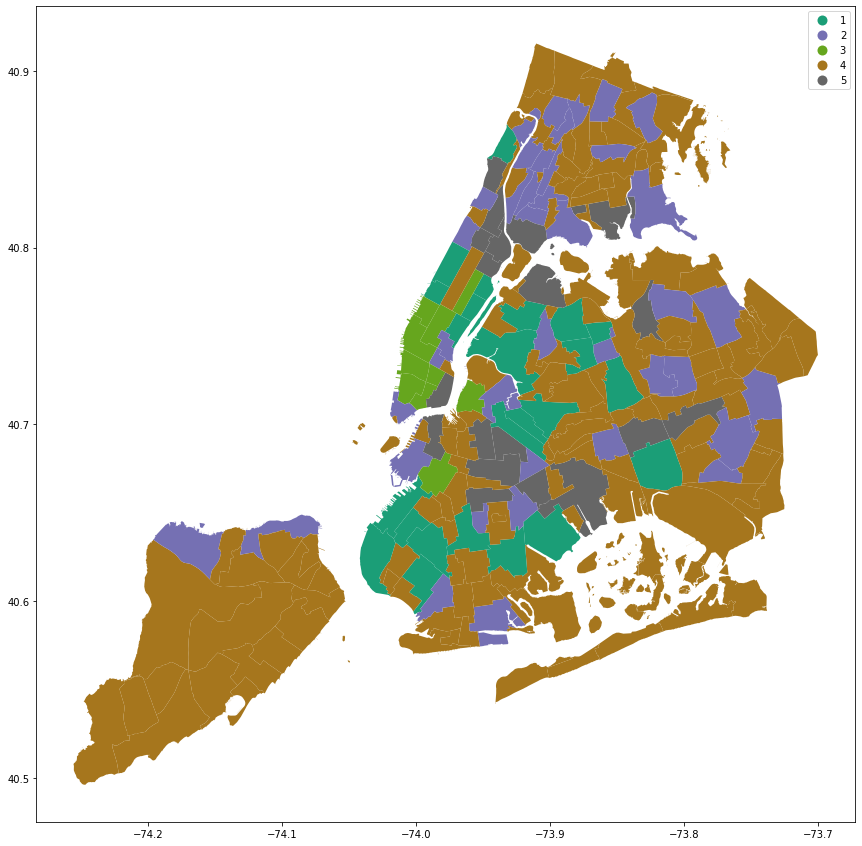

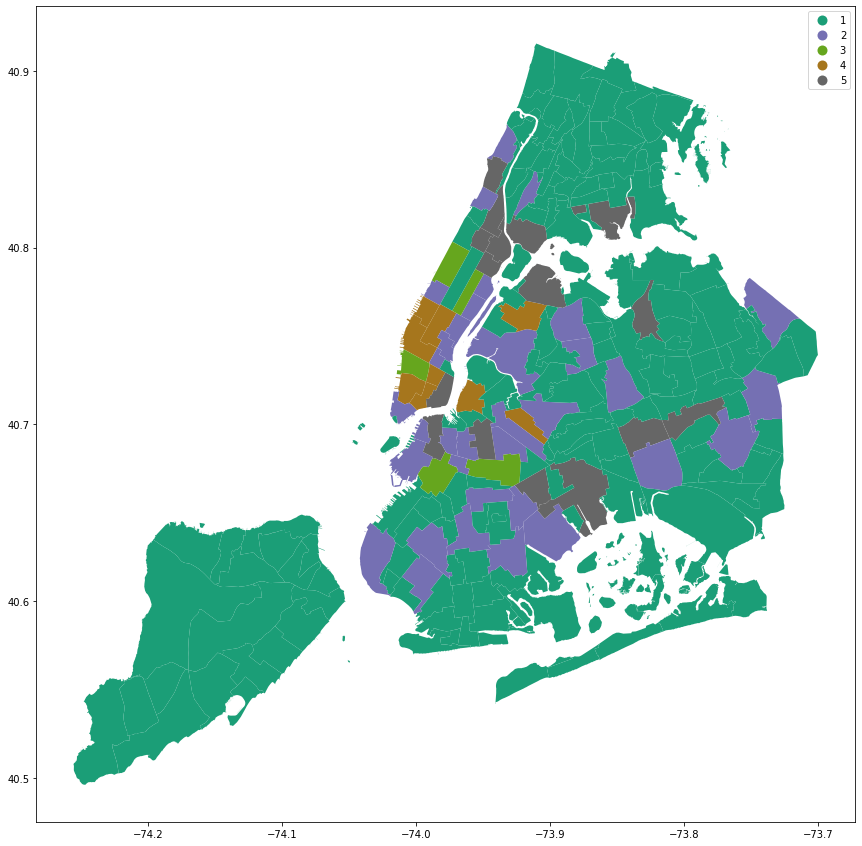

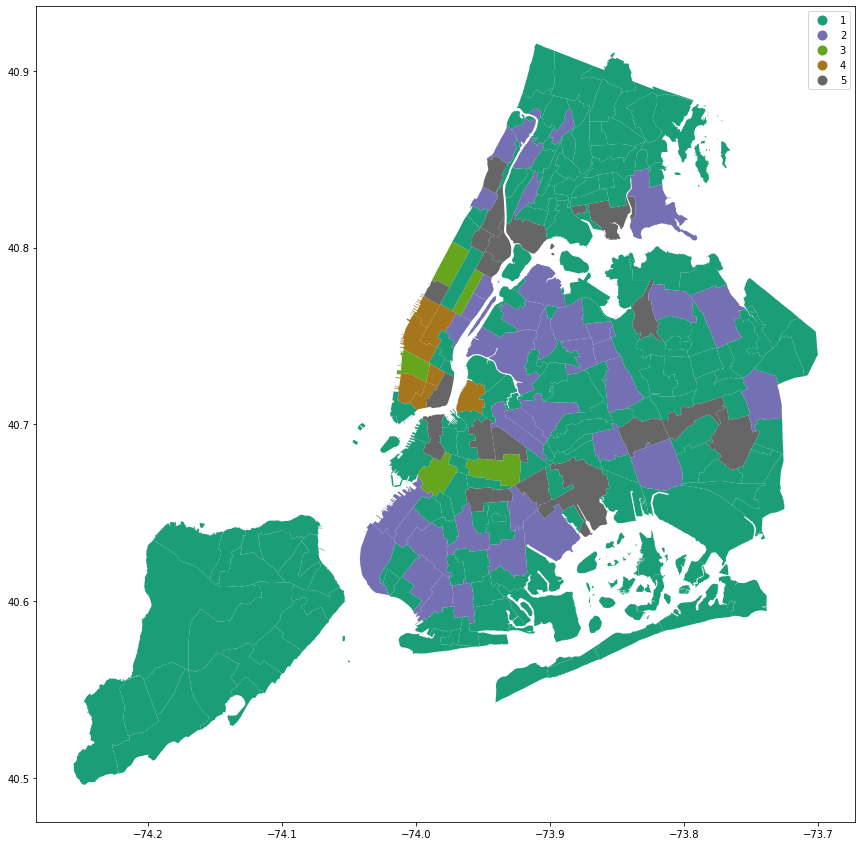

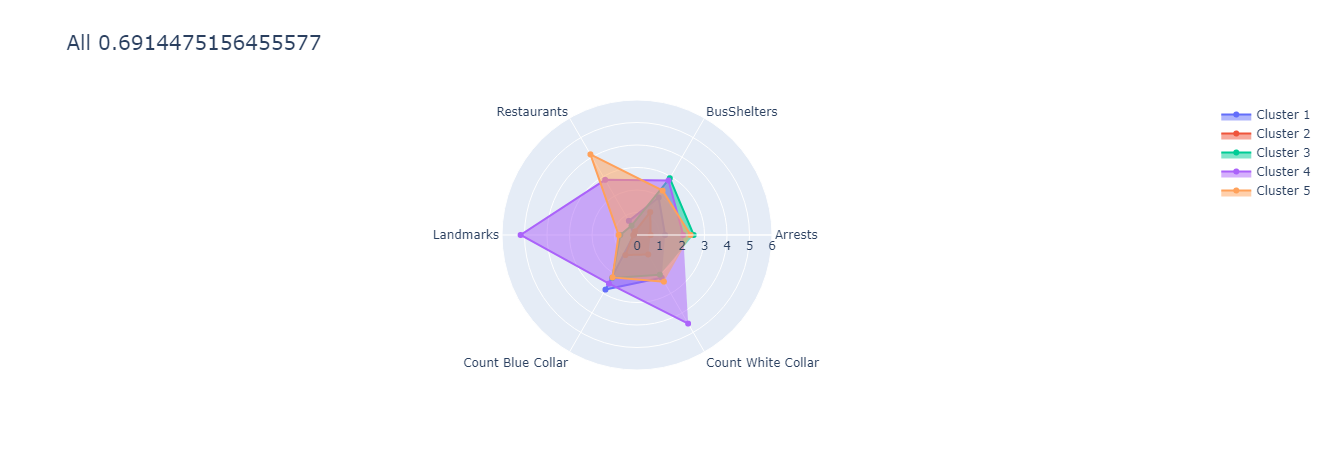

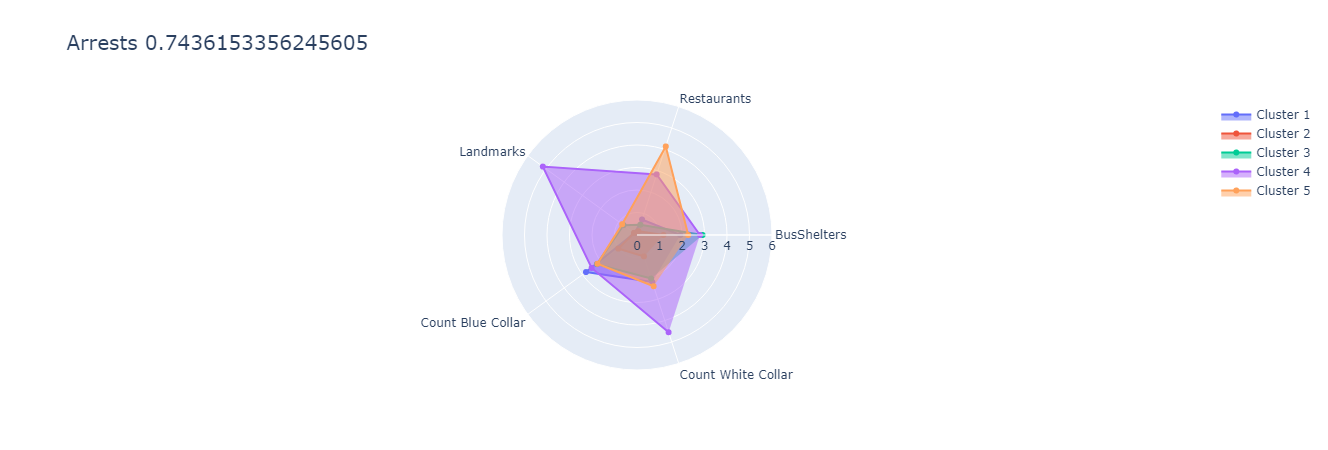

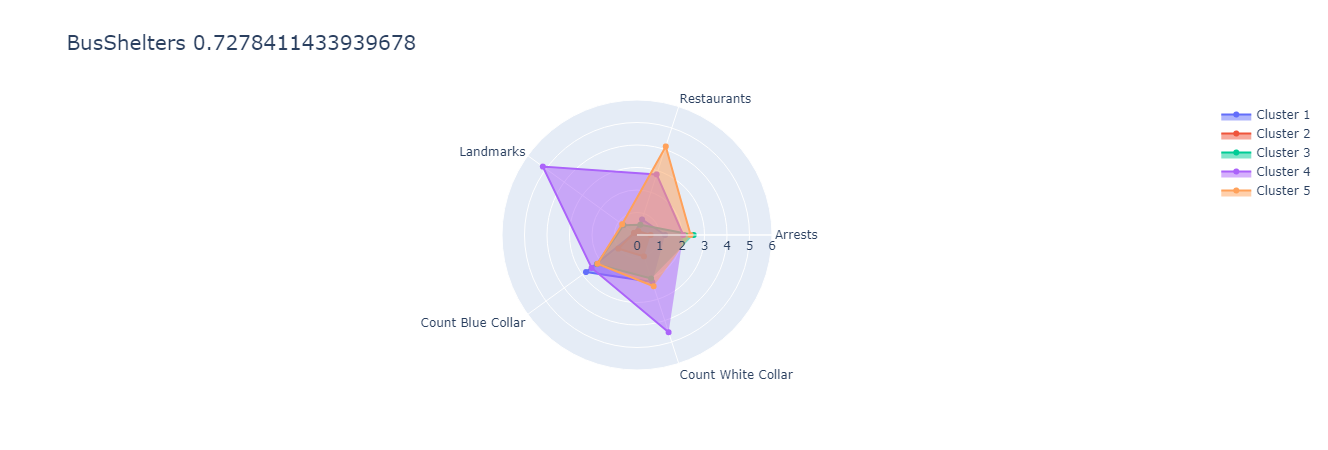

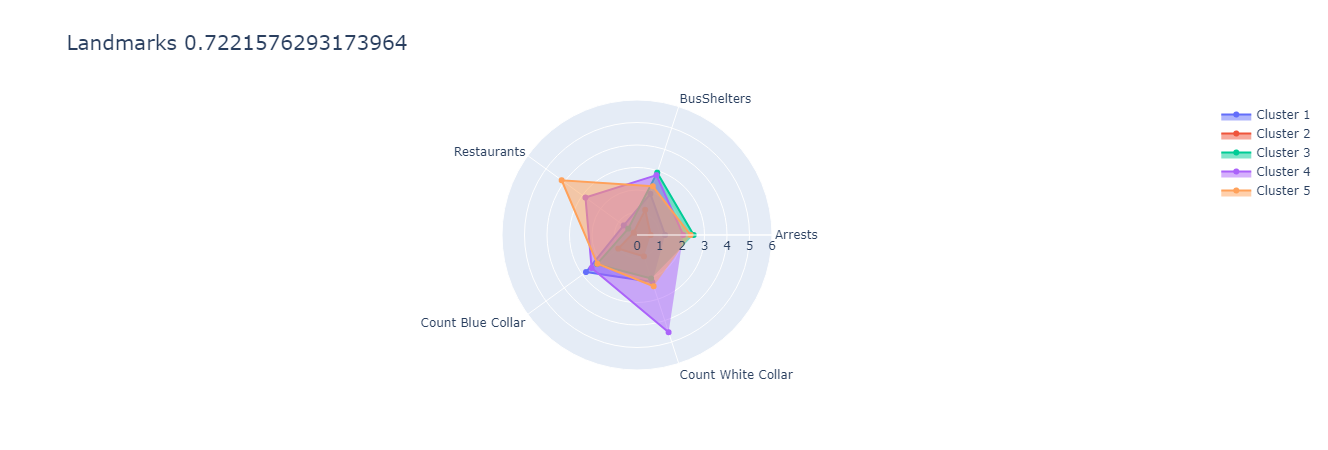

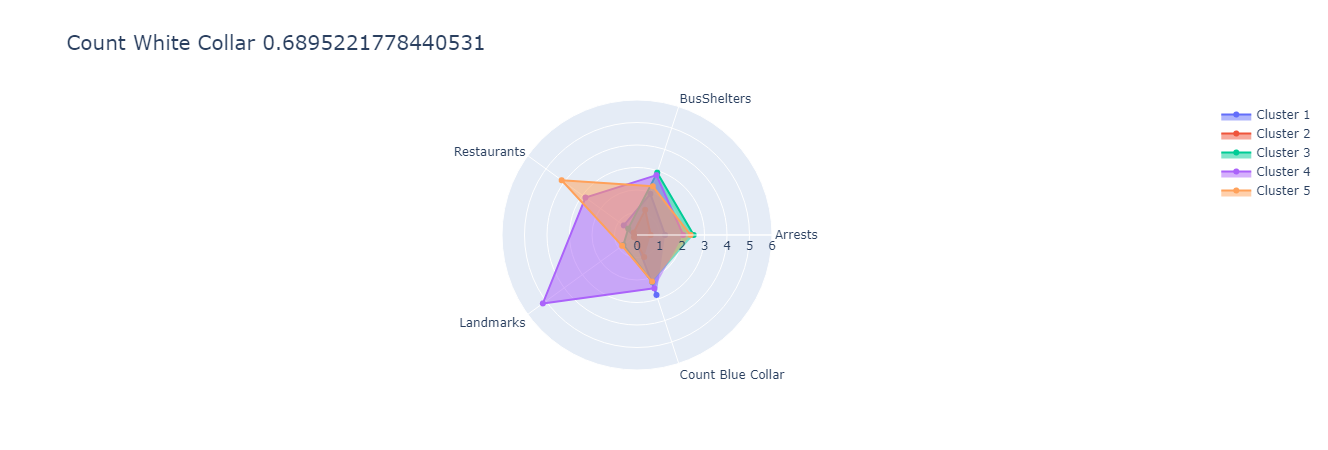

In [8]:
heir_dict = {}
clusters = 5
new_df = df.copy()
features = list(new_df.columns)

#PCA
PCAb = PCA(n_components=2)
PCA_df = PCAb.fit_transform(new_df)
var = PCAb.explained_variance_ratio_.sum()

#Heirarchical
ac = AgglomerativeClustering(affinity='euclidean', linkage='ward', n_clusters = clusters)
y_hc = ac.fit_predict(new_df)
new_df['Cluster'] = y_km+1
nyc = f.visualize_clusters(df_not_scaled,y_hc+1)

#RadarPlot Generation
fig = go.Figure()
for j in range(clusters):
    fig.add_trace(go.Scatterpolar(r=list(new_df[new_df['Cluster'] == j+1].mean()), theta=features, fill='toself', name='Cluster '+ str(j+1)))
    
fig.update_layout(polar=dict(radialaxis=dict(visible=True,range=[0, 6])), showlegend=True)
     
heir_dict['All'] = [var,fig,nyc]

#iterations of dropping features
for i in range(len(col)):
    #drop
    new_df = df.drop(col[i],axis = 1)
    features = list(new_df.columns)
    
    #PCA for variance
    PCAb = PCA(n_components=2)
    PCA_df = PCAb.fit_transform(new_df)
    var = PCAb.explained_variance_ratio_.sum()
    
    #Heirarchical
    ac = AgglomerativeClustering(affinity='euclidean', linkage='ward', n_clusters = clusters)
    y_hc = ac.fit_predict(new_df)
    new_df['Cluster'] = y_km+1
    nyc = f.visualize_clusters(df_not_scaled,y_hc+1)
        
    #RadarPlot Generation
    fig = go.Figure()
    for j in range(clusters):
        fig.add_trace(go.Scatterpolar(r=list(new_df[new_df['Cluster'] == j+1].mean()), theta=features, fill='toself', name='Cluster '+ str(j+1)))
    
    fig.update_layout(polar=dict(radialaxis=dict(visible=True,range=[0, 6])), showlegend=True)
     
    heir_dict[col[i]] = [var,fig,nyc]

#Plotting Radar Charts
for x in heir_dict:
    heir_dict[x][1].update_layout(title_text=x + ' ' + str(heir_dict[x][0]),title_font_size=20)
    heir_dict[x][1].show()